In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ten_stocks = pd.read_csv('15min_df.csv')

In [3]:
pool = ["600094.XSHG",    
        "600160.XSHG", 
        "600008.XSHG",
        "600903.XSHG",
        "000959.XSHE",
        "600970.XSHG",
        "002302.XSHE",
        "600823.XSHG",
        "002503.XSHE",
        "600664.XSHG"]

## Ljung Box Test and Dicket Fuller Test of price

In [4]:
import statsmodels.api as sm

# adfuller test
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput['p-value']  # p<0.05, Stationary

results = pd.DataFrame(columns=['stock', 'ljung_p', 'dickey-fuller_p'])
for stock_name in pool:
    result = {'stock': stock_name, 'ljung_p': sm.stats.acorr_ljungbox(ten_stocks[stock_name].dropna(), lags=[12])[1][0]
             , 'dickey-fuller_p': test_stationarity(ten_stocks[stock_name].dropna())}
    results = results.append(result, ignore_index=True) 
results

,stock,ljung_p,dickey-fuller_p
0,600094.XSHG,0.0,0.399240
1,600160.XSHG,0.0,0.004108
2,600008.XSHG,0.0,0.058631
3,600903.XSHG,0.0,0.011145
4,000959.XSHE,0.0,0.401339
5,600970.XSHG,0.0,0.012710
6,002302.XSHE,0.0,0.189653
7,600823.XSHG,0.0,0.072151
8,002503.XSHE,0.0,0.434175
9,600664.XSHG,0.0,0.431124


## Price plot

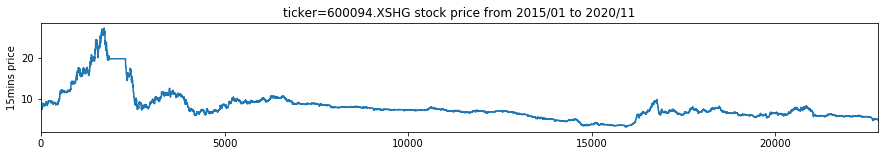

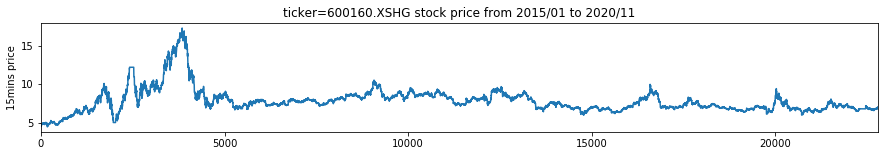

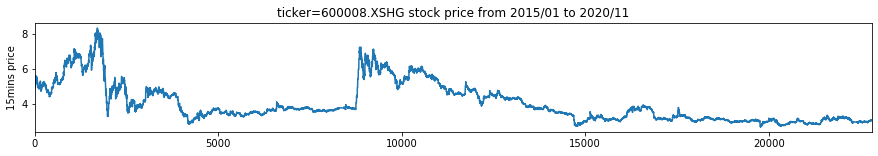

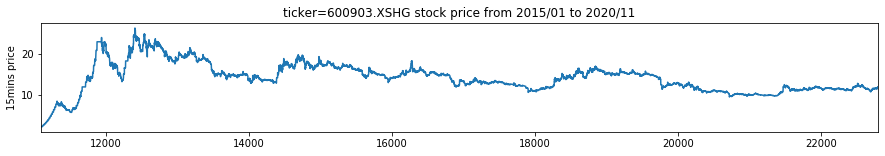

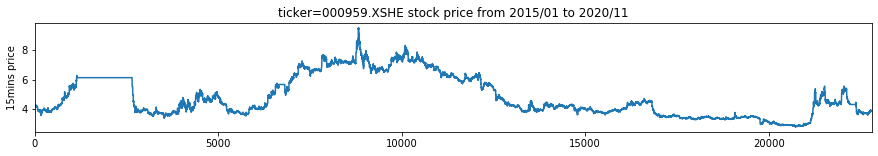

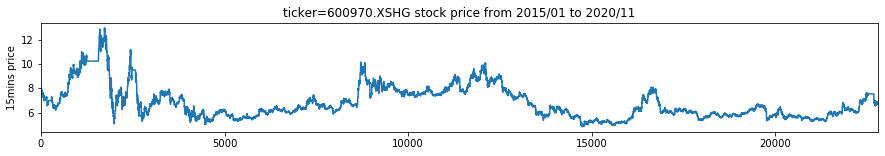

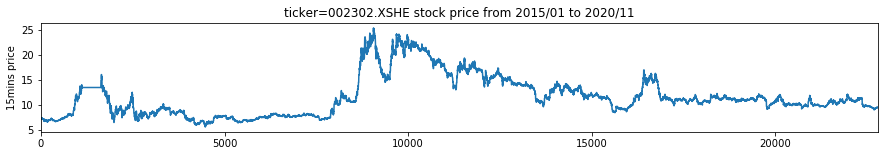

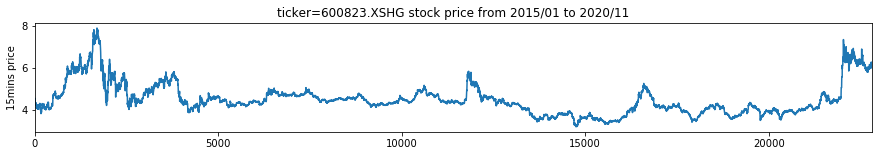

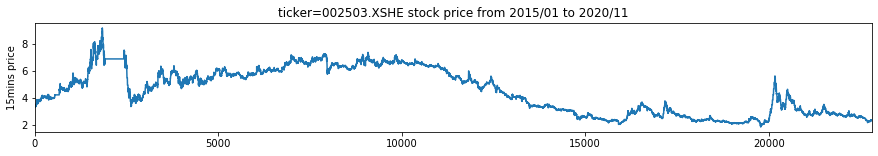

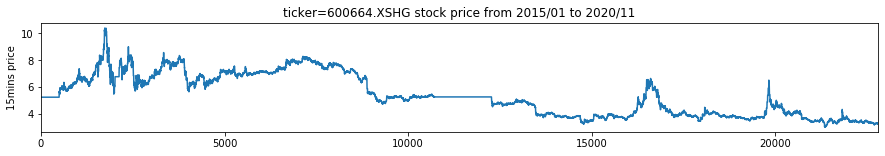

In [5]:
for stock_name in pool:
    ten_stocks[stock_name].dropna().plot(figsize=(15,2))
    plt.ylabel('15mins price')
    plt.title('ticker='+stock_name+' stock price from 2015/01 to 2020/11')
    plt.show()

## Log return plot + ACF/PACF

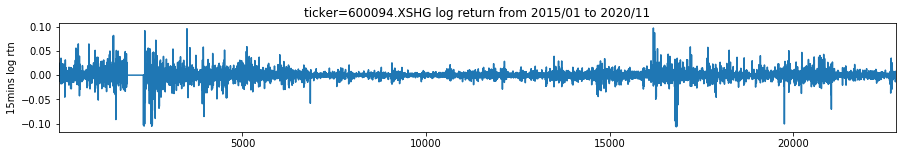

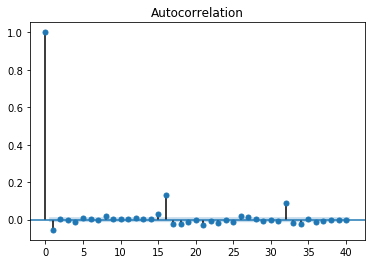

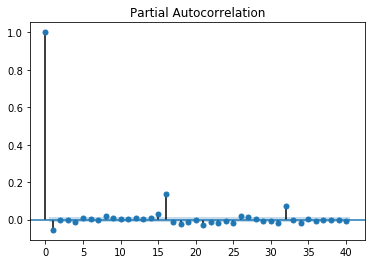

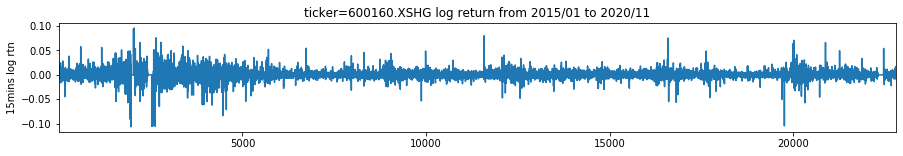

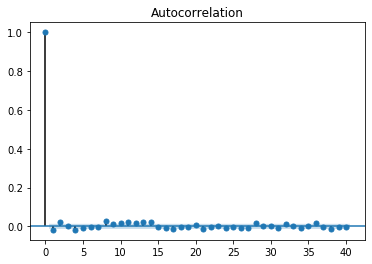

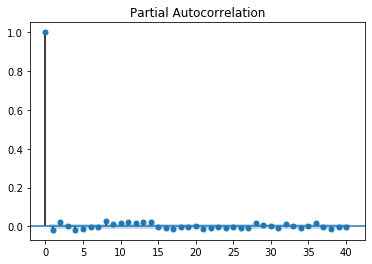

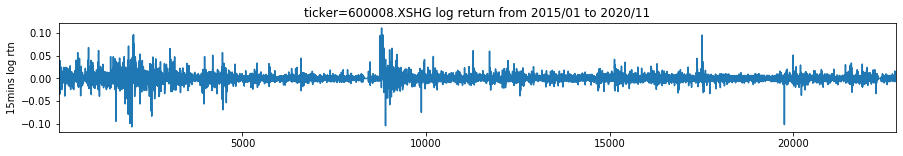

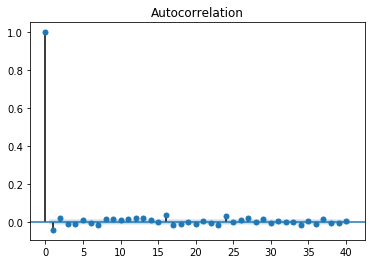

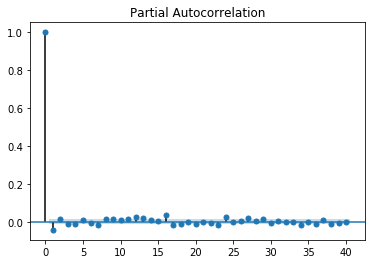

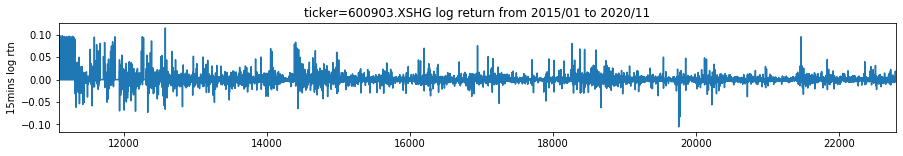

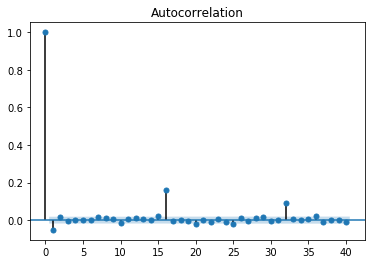

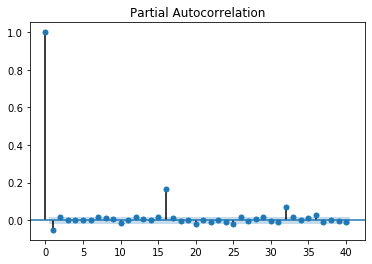

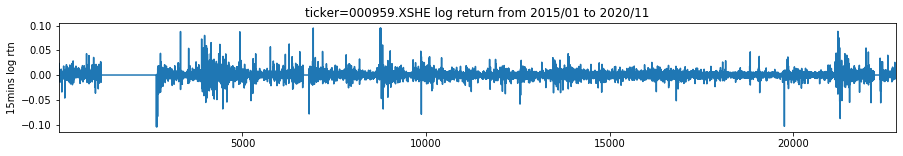

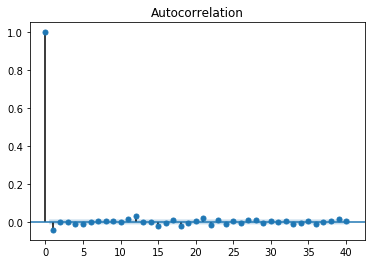

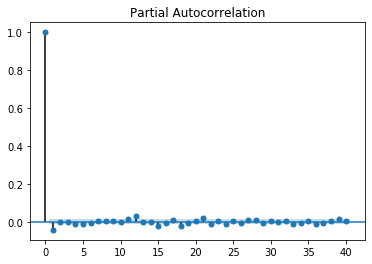

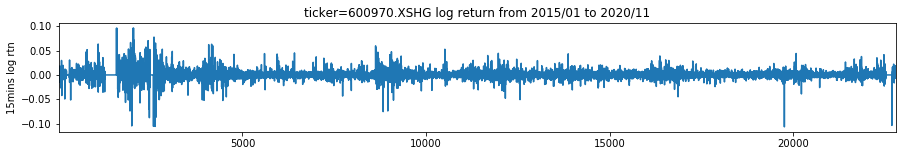

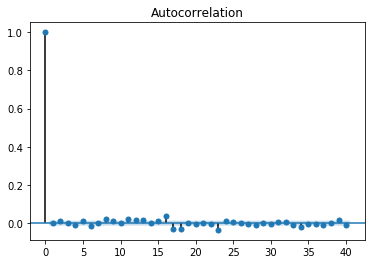

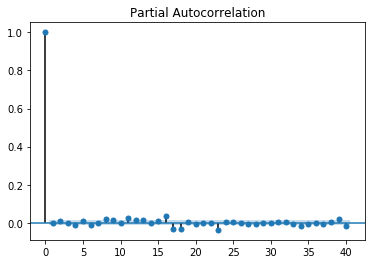

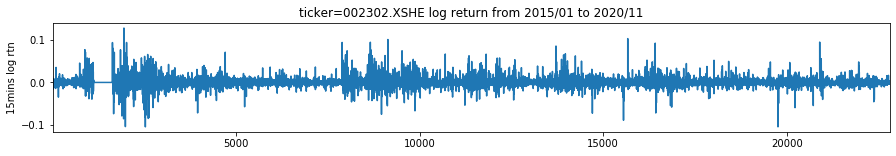

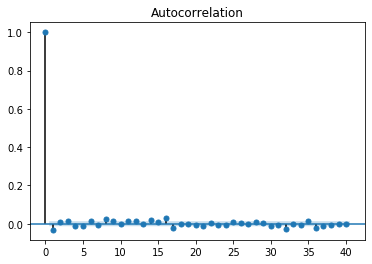

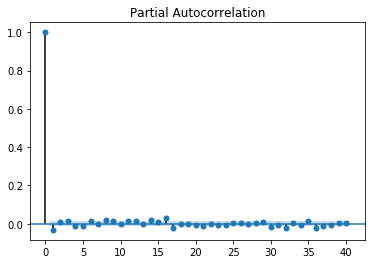

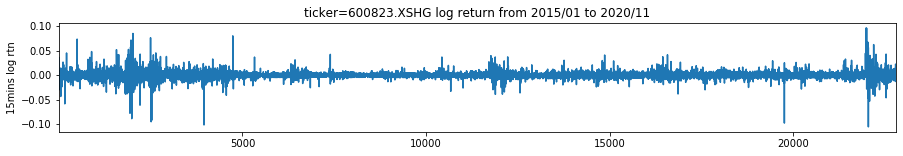

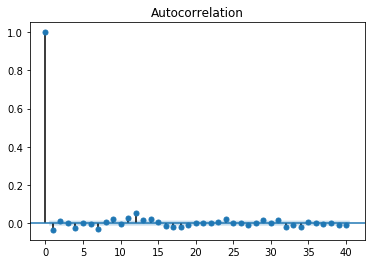

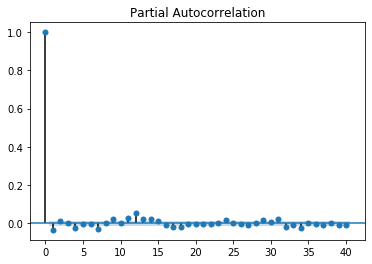

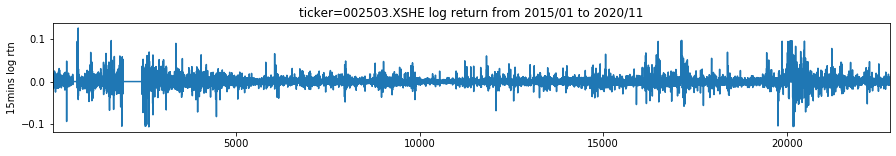

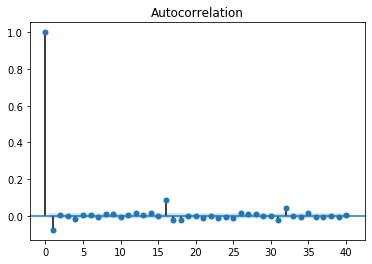

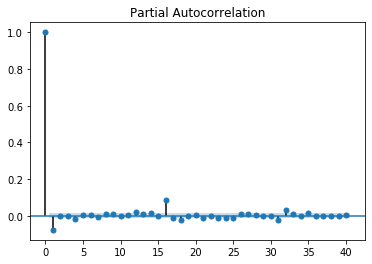

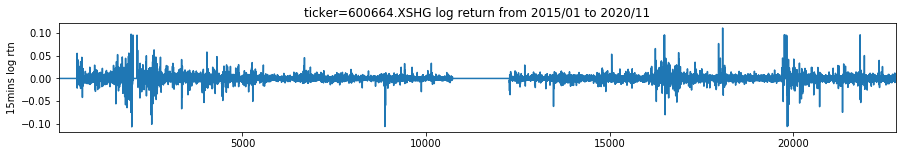

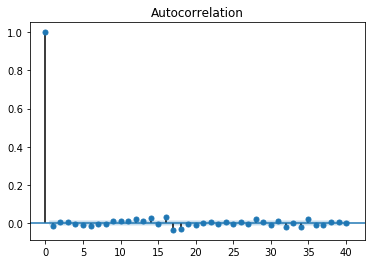

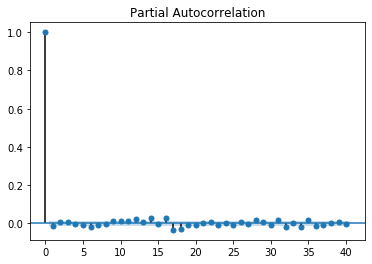

In [6]:
log_rtn_ten = {}
for stock_name in pool:
    log_rtn = np.log(ten_stocks[stock_name]).diff(1).dropna()
    log_rtn_ten[stock_name] = log_rtn
    log_rtn.plot(figsize=(15,2))
    plt.ylabel('15mins log rtn')
    plt.title('ticker='+stock_name+' log return from 2015/01 to 2020/11')
    plt.show()
    sm.graphics.tsa.plot_acf(log_rtn, lags=40) 
    plt.show()
    sm.graphics.tsa.plot_pacf(log_rtn, lags=40)
    plt.show()

## ARMA

In [7]:
import pandas as pd
import itertools
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.arima_model import ARIMA

p = range(5)
q = range(5)

combinations = list(itertools.product(p, q))
combinations = combinations[1:] # Drop (0,0)

results = pd.DataFrame(columns=['stock_name', 'p', 'q', 'ljung_p', 'aic'])

def train_ARMA(param):
    global results
    p = param[0]
    q = param[1]
    print(str(param))
    for stock_name, log_rtn in log_rtn_ten.items():
        try:
            model = ARIMA(log_rtn, order=(p,0,q))

            model_fit = model.fit(disp=0)
            ljung_p = sm.stats.acorr_ljungbox(model_fit.resid, lags=[12-p-q])[1][0]
            aic = model_fit.aic
            results = results.append({'stock_name': stock_name, 'p': p, 'q': q, 'ljung_p': ljung_p, 'aic': aic}, ignore_index=True)
        except:
            continue



for pq in combinations:
    train_ARMA(pq)

results

(0, 1)
(0, 2)
(0, 3)
(0, 4)
(1, 0)
(1, 1)
(1, 2)
(1, 3)
(1, 4)
(2, 0)
(2, 1)
(2, 2)
(2, 3)
(2, 4)
(3, 0)
(3, 1)
(3, 2)
(3, 3)
(3, 4)
(4, 0)
(4, 1)
(4, 2)
(4, 3)
(4, 4)


,stock_name,p,q,ljung_p,aic
0,600094.XSHG,0,1,1.684208e-01,-159973.544091
1,600160.XSHG,0,1,9.536923e-11,-158766.700224
2,600008.XSHG,0,1,2.691840e-05,-161462.557714
3,600903.XSHG,0,1,2.535752e-01,-76042.723059
4,000959.XSHE,0,1,1.815758e-01,-164577.406326
...,...,...,...,...,...
169,600903.XSHG,4,4,8.146759e-01,-76056.284382
170,000959.XSHE,4,4,9.459245e-01,-164586.215557
171,002302.XSHE,4,4,4.623507e-01,-151223.720514
172,600823.XSHG,4,4,5.873249e-01,-168516.685097


In [9]:
results.loc[results[results['ljung_p']>=0.05].groupby(by=["stock_name"])['aic'].idxmin()]

,stock_name,p,q,ljung_p,aic
164,000959.XSHE,4,3,0.847251,-164592.911210
171,002302.XSHE,4,4,0.462351,-151223.720514
102,002503.XSHE,2,3,0.483282,-152195.381879
139,600008.XSHG,4,0,0.050469,-161469.003806
99,600094.XSHG,2,3,0.136040,-160058.745071
29,600664.XSHG,0,3,0.067678,-164139.805045
172,600823.XSHG,4,4,0.587325,-168516.685097
169,600903.XSHG,4,4,0.814676,-76056.284382
158,600970.XSHG,4,2,0.646193,-160008.183879
